# Initialization and Imports

In [1]:
%load_ext dotenv
%dotenv
import os
import math

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['WANDB_NOTEBOOK_NAME'] = 'denoise experiments.ipynb'

In [2]:
import tensorflow as tf
import jax.numpy as np
import time
import matplotlib.pyplot as plt
import cv2
from keras.utils import (
    to_categorical,
)  # Only for categorical one hot encoding
from sklearn.metrics import accuracy_score
import tensorflow_datasets as tfds
import tensorboard
import keras
from keras import layers
from tensorflow_datasets.core.utils import gcs_utils
import os

gcs_utils._is_gcs_disabled = True
import datetime
from IPython.display import clear_output
import tqdm
import pickle
import timeit

2024-05-28 18:19:21.996995: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 18:19:22.058028: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 18:19:23.026861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ashish/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_t

In [3]:
s_wandb_available = False
try:
    import wandb
    from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

    is_wandb_available = True
except Exception as e:
    print("Wandb not available")
    print(e)

# !rm -rf ./logs/
RANDOM_SEED = 42
MODEL_NAME = "DDIM_DiffusionExperiments"

try:
    from google.colab import drive

    drive.mount("/content/gdrive")
    MODEL_PATH = os.path.join(
        "/content/gdrive/My Drive/AI Research/diffusion/models/", MODEL_NAME
    )
except Exception as e:
    MODEL_PATH = os.path.join("models", MODEL_NAME)

TRAIN_LOGDIR = os.path.join(
    "logs", "tensorflow", MODEL_NAME
)  # Sets up a log directory.
# Make sure these directories exist
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(TRAIN_LOGDIR, exist_ok=True)
# Start a profiler server before your model runs.
tf.profiler.experimental.server.start(6009)

Wandb not available
No module named 'wandb'


2024-05-28 18:19:25.605696: I external/local_tsl/tsl/profiler/rpc/profiler_server.cc:46] Profiler server listening on [::]:6009 selected port:6009


In [4]:
# Some Optimizations
import ctypes

_libcudart = ctypes.CDLL("libcudart.so")
# Set device limit on the current device
# cudaLimitMaxL2FetchGranularity = 0x05
pValue = ctypes.cast((ctypes.c_int * 1)(), ctypes.POINTER(ctypes.c_int))
_libcudart.cudaDeviceSetLimit(ctypes.c_int(0x05), ctypes.c_int(128))
_libcudart.cudaDeviceGetLimit(pValue, ctypes.c_int(0x05))
assert pValue.contents.value == 128
tf.compat.v1.ConfigProto.force_gpu_compatible = True

keras.config.set_image_data_format("channels_last")

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-05-28 18:19:26.200124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 25359 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [5]:
# precision_policy = keras.mixed_precision.Policy('mixed_float16')
precision_policy = keras.mixed_precision.Policy("float32")
keras.mixed_precision.set_global_policy(precision_policy)
tf.keras.mixed_precision.set_global_policy(precision_policy)

# Utilities

In [6]:
normalizeImage = lambda x: tf.divide(
    tf.subtract(tf.cast(x, dtype=precision_policy.compute_dtype), 127.5), 127.5
)
denormalizeImage = lambda x: tf.cast(
    tf.add(tf.multiply(x, 127.5), 127.5), dtype=tf.uint8
)

l2normalizeImage = lambda x: tf.math.l2_normalize(x)


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(tf.cast(denormalizeImage(imgs[i, :, :, :]), tf.uint8))
        plt.axis("off")
    plt.show()

In [7]:
@keras.saving.register_keras_serializable()
class KID(keras.metrics.Metric):
    def __init__(self, name, image_size, kid_image_size, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = keras.ops.cast(keras.ops.shape(features_1)[1], dtype="float32")
        return (
            features_1 @ keras.ops.transpose(features_2) / feature_dimensions + 1.0
        ) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = real_features.shape[0]
        batch_size_f = keras.ops.cast(batch_size, dtype="float32")
        mean_kernel_real = keras.ops.sum(kernel_real * (1.0 - keras.ops.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = keras.ops.sum(
            kernel_generated * (1.0 - keras.ops.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = keras.ops.mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

# Data Pipeline

In [8]:
def get_dataset(data_name="celeb_a", batch_size=64, image_scale=256):
    def augmenter(image_scale=256, method="area"):
        @tf.function()
        def augment(sample):
            image = (
                tf.cast(sample["image"], precision_policy.compute_dtype) - 127.5
            ) / 127.5
            image = tf.image.resize(
                image, [image_scale, image_scale], method=method, antialias=True
            )
            image = tf.image.random_flip_left_right(image)

            # Now add some random noise
            processed = {
                "image": image,
            }
            return processed

        return augment

    # Load CelebA Dataset
    data: tf.data.Dataset = tfds.load(data_name, split="all", shuffle_files=True)
    final_data = (
        data
        # .prefetch(tf.data.experimental.AUTOTUNE)
        # .batch(128, num_parallel_calls=tf.data.AUTOTUNE)
        .map(
            augmenter(image_scale, method="area"),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .cache()  # Cache after augmenting to avoid recomputation
        .repeat()  # Repeats the dataset indefinitely
        # .unbatch()
        .shuffle(4096)  # Ensure this is adequate for your dataset size
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return final_data, len(data)

# Diffusion Schedulers

In [9]:
class DiffusionSchedule:
    def __init__(self, timesteps, *args, **kwargs):
        self.timesteps = timesteps

    def generate_timesteps(self, batch_size):
        return tf.random.uniform(
            shape=[batch_size,],
            minval=0,
            maxval=self.timesteps,
            dtype=tf.int32,
        )

    def get_rates(self, t):
        raise NotImplementedError

    # Used while training
    def add_noise(self, images, t, noise):
        raise NotImplementedError

    def remove_all_noise(self, noisy_images, t, noise):
        raise NotImplementedError
    
    # Used to sample from the diffusion model
    def sample_step(self, pred_noise, x, step, step_size=1, clip_denoised=True):
        raise NotImplementedError
    
    # Used while training
    def transform_steps(self, t):
        return t

class DDPMSchedule(DiffusionSchedule):
    def __init__(self, timesteps, beta_start=0.0001, beta_end=0.02):
        self.timesteps = timesteps
        self.betas = self._linear_beta_schedule(timesteps, beta_start, beta_end)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = tf.math.cumprod(self.alphas)

    def _linear_beta_schedule(self, timesteps, beta_start, beta_end):
        return tf.linspace(beta_start, beta_end, timesteps)

    def add_noise(self, images, t, noise):
        sqrt_alpha_bars_t = tf.sqrt(tf.gather(self.alpha_bars, t))
        sqrt_alpha_bars_t = tf.reshape(sqrt_alpha_bars_t, [-1, 1, 1, 1])
        sqrt_one_minus_alpha_bars_t = tf.sqrt(1.0 - tf.gather(self.alpha_bars, t))
        sqrt_one_minus_alpha_bars_t = tf.reshape(
            sqrt_one_minus_alpha_bars_t, [-1, 1, 1, 1]
        )
        return sqrt_alpha_bars_t * images + sqrt_one_minus_alpha_bars_t * noise

    def remove_all_noise(self, noisy_images, t, noise, remove_steps=1):
        # Remove all noise in one step
        # This is the reverse of the add_noise operation
        sqrt_alpha_bars_t = tf.sqrt(tf.gather(self.alpha_bars, t))
        sqrt_alpha_bars_t = tf.reshape(sqrt_alpha_bars_t, [-1, 1, 1, 1])
        sqrt_one_minus_alpha_bars_t = tf.sqrt(1.0 - tf.gather(self.alpha_bars, t))
        sqrt_one_minus_alpha_bars_t = tf.reshape(
            sqrt_one_minus_alpha_bars_t, [-1, 1, 1, 1]
        )
        clean_images = (noisy_images - sqrt_one_minus_alpha_bars_t * noise) / sqrt_alpha_bars_t
        return clean_images

    def sample_step(self, predicted_noise, noisy_images, t, step_size=1, clip_denoised=True):
        alpha_t = tf.gather(self.alphas, t)
        beta_t = tf.gather(self.betas, t)
        alpha_bar_t = tf.gather(self.alpha_bars, t)
        one_minus_alpha_bar_t = 1.0 - alpha_bar_t

        alpha_t = tf.reshape(alpha_t, [-1, 1, 1, 1])
        beta_t = tf.reshape(beta_t, [-1, 1, 1, 1])
        alpha_bar_t = tf.reshape(alpha_bar_t, [-1, 1, 1, 1])
        one_minus_alpha_bar_t = tf.reshape(one_minus_alpha_bar_t, [-1, 1, 1, 1])

        # Compute the posterior mean and variance
        posterior_mean_coeff1 = 1 / tf.sqrt(alpha_t)
        posterior_mean_coeff2 = beta_t / tf.sqrt(1.0 - alpha_bar_t)

        mean = posterior_mean_coeff1 * (
            noisy_images - posterior_mean_coeff2 * predicted_noise
        )
        variance = (1 - alpha_t) / (1 - alpha_bar_t)

        noise = tf.random.normal(shape=noisy_images.shape, mean=0.0, stddev=1.0)
        noisy_images = mean + tf.sqrt(variance) * noise

        t = tf.maximum(t - 1, 0)

        return noisy_images


class GaussianDiffusion(DiffusionSchedule):
    def __init__(
        self,
        timesteps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        clip_min=-1.0,
        clip_max=1.0,
    ):
        super().__init__(timesteps)
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.clip_min = clip_min
        self.clip_max = clip_max

        # Define the linear variance schedule
        self.betas = betas = np.linspace(
            beta_start,
            beta_end,
            timesteps,
            dtype=np.float64,  # Using float64 for better precision
        )
        self.num_timesteps = int(timesteps)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.betas = tf.constant(betas, dtype=tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)

        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = tf.constant(
            np.sqrt(alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_one_minus_alphas_cumprod = tf.constant(
            np.sqrt(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.log_one_minus_alphas_cumprod = tf.constant(
            np.log(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_recip_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod), dtype=tf.float32
        )
        self.sqrt_recipm1_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod - 1), dtype=tf.float32
        )

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)

        # Log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = tf.constant(
            np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32
        )

        self.posterior_mean_coef1 = tf.constant(
            betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

        self.posterior_mean_coef2 = tf.constant(
            (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

    def _extract(self, a, t, x_shape):
        """Extract some coefficients at specified timesteps,
        then reshape to [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.

        Args:
            a: Tensor to extract from
            t: Timestep for which the coefficients are to be extracted
            x_shape: Shape of the current batched samples
        """
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1, 1, 1])

    def q_mean_variance(self, x_start, t):
        """Extracts the mean, and the variance at current timestep.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
        """
        x_start_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start_shape)
        log_variance = self._extract(
            self.log_one_minus_alphas_cumprod, t, x_start_shape
        )
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise):
        """Diffuse the data.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
            noise: Gaussian noise to be added at the current timestep
        Returns:
            Diffused samples at timestep `t`
        """
        x_start_shape = tf.shape(x_start)
        return (
            self._extract(self.sqrt_alphas_cumprod, t, tf.shape(x_start)) * x_start
            + self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape)
            * noise
        )

    def predict_start_from_noise(self, x_t, t, noise):
        x_t_shape = tf.shape(x_t)
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
            - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """Compute the mean and variance of the diffusion
        posterior q(x_{t-1} | x_t, x_0).

        Args:
            x_start: Stating point(sample) for the posterior computation
            x_t: Sample at timestep `t`
            t: Current timestep
        Returns:
            Posterior mean and variance at current timestep
        """

        x_t_shape = tf.shape(x_t)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(
            self.posterior_log_variance_clipped, t, x_t_shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, pred_noise, x, t, clip_denoised=True):
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t
        )
        return model_mean, posterior_variance, posterior_log_variance

    def p_sample(self, pred_noise, x, t, clip_denoised=True):
        """Sample from the diffusion model.

        Args:
            pred_noise: Noise predicted by the diffusion model
            x: Samples at a given timestep for which the noise was predicted
            t: Current timestep
            clip_denoised (bool): Whether to clip the predicted noise
                within the specified range or not.
        """
        model_mean, _, model_log_variance = self.p_mean_variance(
            pred_noise, x=x, t=t, clip_denoised=clip_denoised
        )
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        # No noise when t == 0
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1]
        )
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise

    def sample_step(self, pred_noise, noisy_images, t, step_size=1, clip_denoised=True):
        return self.p_sample(pred_noise, noisy_images, t, clip_denoised)

    def get_rates(self, t):
        return tf.gather(self.sqrt_alphas_cumprod, t), tf.gather(self.sqrt_one_minus_alphas_cumprod, t)
    
    def add_noise(self, images, t, noise):
        return self.q_sample(images, t, noise)

    def remove_all_noise(self, noisy_images, t, noise):
        # This is the reverse of the add_noise operation
        clean_images = self.predict_start_from_noise(noisy_images, t, noise)
        return clean_images

class DDIMSchedule:
    def __init__(self, timesteps, min_signal_rate = 0.02, max_signal_rate = 0.95, *args, **kwargs):
        self.timesteps = timesteps
        self.min_signal_rate = min_signal_rate
        self.max_signal_rate = max_signal_rate
        self.start_angle = keras.ops.cast(keras.ops.arccos(self.max_signal_rate), "float32")
        self.end_angle = keras.ops.cast(keras.ops.arccos(self.min_signal_rate), "float32")
        self.angle_range = self.end_angle - self.start_angle

    def generate_timesteps(self, batch_size):
        return tf.random.uniform(
            shape=[batch_size,],
            minval=0,
            maxval=self.timesteps,
            dtype=tf.float32,
        )

    @tf.function(jit_compile=True)
    def get_rates(self, t):
        # diffusion times -> angles

        diffusion_angles = self.start_angle + t * (self.angle_range)

        # angles -> signal and noise rates
        signal_rates = keras.ops.cos(diffusion_angles)
        noise_rates = keras.ops.sin(diffusion_angles)
        # signal_rates = keras.ops.reshape(signal_rates, [-1, 1, 1, 1])
        # noise_rates = keras.ops.reshape(noise_rates, [-1, 1, 1, 1])
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1
        return signal_rates, noise_rates

    @tf.function(jit_compile=True)
    def add_noise(self, images, t, noise): 
        # Scale 't' to the range [0, 1]
        t = keras.ops.cast(t, "float32") / self.timesteps
        signal_rates, noise_rates = self.get_rates(t)
        return signal_rates * images + noise_rates * noise

    def remove_all_noise(self, noisy_images, t, noise):
        # Scale 't' to the range [0, 1]
        t = keras.ops.cast(t, "float32") / self.timesteps
        signal_rates, noise_rates = self.get_rates(t)
        pred_images = (noisy_images - noise_rates * noise) / signal_rates
        return pred_images
    
    # @tf.function(jit_compile=True)
    def sample_step(self, pred_noise, noisy_images, steps, step_size=1, clip_denoised=True):
        t = keras.ops.cast(steps, "float32") / self.timesteps
        signal_rates, noise_rates = self.get_rates(t)
        pred_images = (noisy_images - noise_rates * pred_noise) / signal_rates
        # if clip_denoised:
        #     pred_images = keras.ops.clip(pred_images, -1.0, 1.0)
        next_t = tf.maximum(steps - step_size, 0)
        next_t = keras.ops.cast(next_t, "float32") / self.timesteps
        next_signal_rates, next_noise_rates = self.get_rates(next_t)
        samples = next_signal_rates * pred_images + next_noise_rates * pred_noise
        return samples

    # @tf.function(jit_compile=True)
    def transform_steps(self, t):
        t = keras.ops.cast(t, "float32") / self.timesteps
        signal_rates, noise_rates = self.get_rates(t)
        # noise_rates = keras.ops.reshape(noise_rates, [-1])
        return noise_rates**2

2024-05-26 18:19:01.072699: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


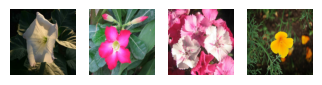

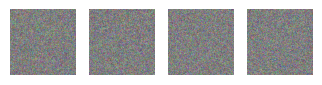

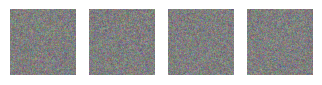

In [64]:
# Visualize adding some noise to some sample images and then removing it
data, _ = get_dataset("oxford_flowers102", batch_size=4, image_scale=256)
images = next(iter(data))["image"]
plotImages(images)
noise_level = 999 * tf.ones(shape=(4,), dtype=tf.int64)
noise_level_max = 1000
schedule = DDIMSchedule(timesteps=noise_level_max)
noise = tf.random.normal(shape=images.shape)
noisy_images = schedule.add_noise(images, noise_level, noise)
plotImages(noisy_images)
plotImages(noise)

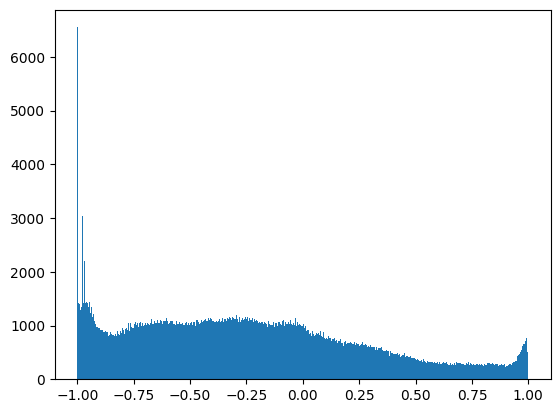

In [45]:
plt.hist(images.numpy().flatten(), bins=1000)
plt.show()

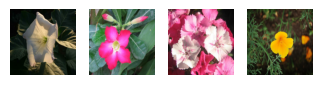

In [65]:
# noise = tf.random.normal(shape=images.shape)
reconstructed_images = schedule.remove_all_noise(noisy_images, noise_level, noise)
plotImages(reconstructed_images)

In [53]:
tf.reduce_mean(reconstructed_images), tf.math.reduce_variance(reconstructed_images), tf.reduce_min(reconstructed_images)

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.27575475>,
 <tf.Tensor: shape=(), dtype=float32, numpy=24.030998>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-22.072784>)

In [ ]:
# Plot his

# Modeling

In [10]:
class Monitor(keras.callbacks.Callback):
    metrics_description_table = {
        "loss": "Training Loss",
        "kid_score": "KID Score",
        "n_loss": "Noise Loss",
        "i_loss": "Image Loss",
        # "k_loss": "Kid Loss",
        "kl_loss": "KL Loss",
    }
    def __init__(
        self,
        batch_size=64,
        tf_logdir="./logs/tensorflow",
    ):
        super().__init__()
        self.batch_size = batch_size
        self.tf_writer = tf.summary.create_file_writer(os.path.join(tf_logdir, 'train'))

    def on_batch_end(self, batch, logs):
        if tf.math.mod(batch, 100) == 0:
            with self.tf_writer.as_default():
                for metric, value in logs.items():
                    better_key = self.metrics_description_table.get(metric, metric)
                    tf.summary.scalar(better_key, value, step=self.model.train_step_counter)
        

In [11]:
@keras.saving.register_keras_serializable()
class PixelReshuffle(keras.Layer):
    def __init__(self, upscale_factor, **kwargs):
        super(PixelReshuffle, self).__init__(**kwargs)
        self.upscale_factor = upscale_factor

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.upscale_factor)

    def compute_output_shape(self, input_shape):
        height, width, channels = input_shape[1], input_shape[2], input_shape[3]
        new_height = height * self.upscale_factor
        new_width = width * self.upscale_factor
        new_channels = channels // (self.upscale_factor**2)
        return (input_shape[0], new_height, new_width, new_channels)

    def get_config(self):
        config = super(PixelReshuffle, self).get_config()
        config.update({"upscale_factor": self.upscale_factor})
        return config


# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return keras.initializers.VarianceScaling(
        scale, mode="fan_avg", distribution="normal"
    )

@tf.function(jit_compile=True)
def hw_flatten(x):
    inp_shape = tf.shape(x)
    # inp_shape = x.shape
    batch_size, height, width, channels = inp_shape[0], inp_shape[1], inp_shape[2], inp_shape[3]
    shape = [batch_size, height * width, channels]
    return tf.reshape(x, shape=shape)

@keras.saving.register_keras_serializable()
class AttentionBlock(layers.Layer):
    def __init__(self, channelReduce=1, name=None, initializers=kernel_init(1.0), groups=8, units=1, **kwargs):
        super(AttentionBlock, self).__init__(name=name, **kwargs)
        self.channelReduce = channelReduce
        self.initializers = initializers
        self.norm = layers.GroupNormalization(groups=groups)

    def get_config(self):
        config = {"name": self.name}
        base_config = super(AttentionBlock, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def get_weights(self):
        return [self.gamma, self.kernel_f, self.kernel_g, self.kernel_h]
        
    def compute_output_shape(self, input_shape):
        return input_shape

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.filters_f_g = self.channels // self.channelReduce
        self.filters_h = self.channels

        kernel_shape_f_g = (1, 1) + (self.channels, self.filters_f_g)
        kernel_shape_h = (1, 1) + (self.channels, self.filters_h)

        # Create a trainable weight variable for this layer:
        self.gamma = self.add_weight(
            name="gamma", shape=[1], initializer="zeros", trainable=True
        )
        self.kernel_f = self.add_weight(
            shape=kernel_shape_f_g,
            initializer=self.initializers,
            name="kernel_f",
            trainable=True,
        )
        self.kernel_g = self.add_weight(
            shape=kernel_shape_f_g,
            initializer=self.initializers,
            name="kernel_g",
            trainable=True,
        )
        self.kernel_h = self.add_weight(
            shape=kernel_shape_h,
            initializer=self.initializers,
            name="kernel_h",
            trainable=True,
        )

        super(AttentionBlock, self).build(input_shape)
        self.built = True

    def call(self, inp):
        # input = [NHWC]
        inp = self.norm(inp)
        f_x = tf.nn.conv2d(inp, filters=self.kernel_f, strides=(1, 1), padding="SAME")
        g_x = tf.nn.conv2d(inp, filters=self.kernel_g, strides=(1, 1), padding="SAME")
        h_x = tf.nn.conv2d(inp, filters=self.kernel_h, strides=(1, 1), padding="SAME")

        f_x_flat = hw_flatten(f_x)  # [N(HW)C]
        g_x_flat = hw_flatten(g_x)  # [N(HW)C]

        s = tf.keras.backend.batch_dot(g_x_flat, tf.keras.backend.permute_dimensions(f_x_flat, (0, 2, 1)))

        beta = tf.nn.softmax(s, axis=-1)
        o = tf.keras.backend.batch_dot(beta, hw_flatten(h_x))

        o = tf.reshape(o, shape=tf.shape(inp))  # [bs, h, w, C]
        x = self.gamma * o + inp
        return x

# class AttentionBlock(layers.Layer):
#     """Applies self-attention.

#     Args:
#         units: Number of units in the dense layers
#         groups: Number of groups to be used for GroupNormalization layer
#     """

#     def __init__(self, units, groups=8, **kwargs):
#         self.units = units
#         self.groups = groups
#         super().__init__(**kwargs)

#         self.norm = layers.GroupNormalization(groups=groups)
#         self.query = layers.Dense(units, kernel_initializer=kernel_init(1.0))
#         self.key = layers.Dense(units, kernel_initializer=kernel_init(1.0))
#         self.value = layers.Dense(units, kernel_initializer=kernel_init(1.0))
#         self.proj = layers.Dense(units, kernel_initializer=kernel_init(0.0))

#     @tf.function(jit_compile=True)
#     def call(self, inputs):
#         batch_size = tf.shape(inputs)[0]
#         height = tf.shape(inputs)[1]
#         width = tf.shape(inputs)[2]
#         scale = tf.cast(self.units, tf.float32) ** (-0.5)

#         inputs = self.norm(inputs)
#         q = self.query(inputs)
#         k = self.key(inputs)
#         v = self.value(inputs)

#         attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
#         attn_score = tf.reshape(attn_score, [batch_size, height, width, height * width])

#         attn_score = tf.nn.softmax(attn_score, -1)
#         attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])

#         proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)
#         proj = self.proj(proj)
#         return inputs + proj

In [13]:
class TimeEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        half_dim = dim // 2
        self.emb = math.log(10000) / (half_dim - 1)
        self.emb = keras.ops.exp(keras.ops.arange(half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        inputs = keras.ops.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = keras.ops.concatenate([keras.ops.sin(emb), keras.ops.cos(emb)], axis=-1)
        return emb
    
class SinusoidalEmbedding(layers.Layer):
    def __init__(self, dim, embedding_max_frequency=1000, **kwargs):
        super().__init__(**kwargs)
        embedding_min_frequency = 1.0
        frequencies = keras.ops.exp(
            keras.ops.linspace(
                keras.ops.log(embedding_min_frequency),
                keras.ops.log(embedding_max_frequency),
                dim // 2,
            )
        )
        self.emb = keras.ops.cast(2.0 * math.pi * frequencies, "float32")
    
    def call(self, inputs):
        inputs = keras.ops.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = keras.ops.concatenate([keras.ops.sin(emb), keras.ops.cos(emb)], axis=-1)
        return emb
    
@keras.saving.register_keras_serializable()
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    embedding_max_frequency = 1000.0
    embedding_dims = 32
    frequencies = keras.ops.exp(
        keras.ops.linspace(
            keras.ops.log(embedding_min_frequency),
            keras.ops.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = keras.ops.cast(2.0 * math.pi * frequencies, "float32")
    embeddings = keras.ops.concatenate(
        [keras.ops.sin(angular_speeds * x), keras.ops.cos(angular_speeds * x)], axis=3
    )
    return embeddings

def TimeMLP(units, activation_fn):
    def apply(inputs):
        # temb = layers.Dense(units, activation=activation_fn, kernel_initializer=kernel_init(1.0))(inputs)
        temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(inputs)
        temb = layers.GroupNormalization(groups=8)(temb)
        temb = layers.Activation(activation_fn)(temb)
        return temb

    return apply

def conv_layer(conv_type, features, kernel_size, strides=(1, 1), padding='same', name=None, initializer=kernel_init(1.0), use_bias=True, activation=None):
    if conv_type == "conv":
        return layers.Conv2D(
            features,
            kernel_size,
            strides=strides,
            padding=padding,
            name=name,
            kernel_initializer=initializer,
            use_bias=use_bias,
            activation=activation,
        )
    elif conv_type == "separable":
        return layers.SeparableConv2D(
            features,
            kernel_size,
            strides=strides,
            padding=padding,
            name=name,
            depthwise_initializer=initializer,
            pointwise_initializer=initializer,
            use_bias=use_bias,
            activation=activation,
        )
    elif conv_type == "conv_transpose":
        return layers.Conv2DTranspose(
            features,
            kernel_size,
            strides=strides,
            padding=padding,
            name=name,
            kernel_initializer=initializer,
            use_bias=use_bias,
            activation=activation,
        )
    else:
        raise ValueError(f"Invalid convolution type: {conv_type}")
                
def residual_block(features, kernel_size, strides, padding, activation, direction, res, groups=8, attention=False):
    def apply(x):
        x, t = x
        residual = x
        input_width = x.shape[-1]
        if input_width != features:
            residual = conv_layer(
                "conv",
                features,
                1,
                strides=1,
                padding="same",
                name=f"{direction}_{res}_conv0",
                initializer=kernel_init(1.0),
            )(x)

        x = conv_layer(
            "conv",features,kernel_size,strides=strides,
            padding=padding,name=f"{direction}_{res}_conv1",initializer=kernel_init(1.0),
        )(x)
        
        temb = layers.Dense(features, kernel_initializer=kernel_init(1.0))(t)[:, None, None, :]
        x = layers.Add()([x, temb])
        x = layers.GroupNormalization(groups=groups, name=f"{direction}_{res}_bn1")(x)
        x = layers.Activation(activation, name=f"{direction}_{res}_act1")(x)

        x = conv_layer(
            "conv",features,kernel_size,strides=strides,
            padding=padding,name=f"{direction}_{res}_conv2",initializer=kernel_init(1.0),
        )(x)

        x = layers.Add()([x, residual])

        if attention:
            x = AttentionBlock(features, groups=groups)(x)
        return x
    return apply

def UpsampleBlock(scale, features, name=None):
    def apply(inputs):
        x = PixelReshuffle(scale, name=f'{name}_pixel_reshuffle')(inputs)
        return x
    return apply

def generate_unet(
    input_shape,
    activation_fn=keras.activations.mish,
    norm_groups=8,
    num_res_blocks=1,
    embedding_type=None,
):
    # Generate a unet model with residual connections
    inputs = keras.Input(shape=input_shape, name="input")
    time_input = keras.Input(shape=(1, 1, 1), dtype=tf.float32, name="time_input")
    res = input_shape[1]
    x = inputs
    feature_depths = [32, 64, 96, 128]
    should_use_attention = [True, True, True, True]

    temb = layers.Reshape(())(time_input)
    if embedding_type in [None, "time"]:
        temb = TimeEmbedding(dim=feature_depths[0] * 4)(temb)
    elif embedding_type == "sinusoidal":
        temb = SinusoidalEmbedding(dim=feature_depths[0]*4)(temb)
    temb = TimeMLP(units=feature_depths[0] * 4, activation_fn=activation_fn)(temb)
    # temb = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, 32))(time_input)
    # temb = layers.UpSampling2D(size=res, interpolation="nearest")(temb)

    x = conv_layer(
        "conv",
        64,
        1,
        strides=1,
        padding="same",
        name="input_conv",
        initializer=kernel_init(1.0),
    )(x)
    print(f"Input: {x.shape}")
    downsample_layers = [x]
    x = layers.GroupNormalization(groups=norm_groups)(x)
    x = layers.Activation(activation_fn)(x)

    for features, should_attention in zip(feature_depths, should_use_attention):
        for i in range(num_res_blocks):
            x = residual_block(features, 3, 1, "same", 
                               activation=activation_fn, direction=f"down{i}",
                               res=res, groups=norm_groups, attention=should_attention)([x, temb])
            print(f"Residual down Block: {res} {x.shape}")
            downsample_layers.append(x)
            x = layers.GroupNormalization(groups=norm_groups)(x)
            residual = x
            x = layers.Activation(activation_fn)(x)
        # x = layers.AveragePooling2D(2, name=f"downsample_{res}")(x)
        if features != feature_depths[-1]:
            x = conv_layer(
                "conv",
                features, 3, strides=2, 
                padding="same", name=f"downsample_{res}",
                initializer=kernel_init(1.0),
            )(x)
            print(f"Downsample: {res} {x.shape}")
            downsample_layers.append(x)
            x = layers.GroupNormalization(groups=norm_groups)(x)
            residual = layers.AveragePooling2D(2)(residual)
            x = layers.Concatenate()([x, residual])
            x = layers.Activation(activation_fn)(x)
            res = res // 2

    x = residual_block(feature_depths[-1], 3, 1, "same", activation_fn, "middle", res, groups=norm_groups, attention=should_use_attention)([x, temb])
    # x = layers.GroupNormalization(groups=norm_groups)(x)
    # x = layers.Activation(activation_fn)(x)
    # x = layers
    # x = residual_block(1024, 3, 1, "same", activation_fn, "middle2", res, groups=norm_groups)([x, temb])
    # x = UpsampleBlock(2, feature_depths[-1], name="middle_upsample")(x)
    
    upsample_layers = []
    for features, should_attention in zip(reversed(feature_depths), reversed(should_use_attention)):
        for i in range(num_res_blocks + 1):
            downsample = downsample_layers.pop()
            print(f"Residual up Block: {res} {downsample.shape} {x.shape}")
            x = layers.Concatenate(axis=-1)([x, downsample])
            x = layers.GroupNormalization(groups=norm_groups)(x)
            x = layers.Activation(activation_fn)(x)
            x = residual_block(features, 3, 1, "same", 
                               activation=activation_fn, direction=f"up{i}", 
                               res=res, groups=norm_groups, attention=should_attention)([x, temb])
        if features != feature_depths[0]:
            x = UpsampleBlock(2, features, name=f"upsample_{res}")(x)
            # x = layers.GroupNormalization(groups=norm_groups)(x)
        upsample_layers.append(x)
        res = res * 2

    x = layers.Conv2D(
        3, 3, 
        strides=1, 
        padding="same", 
        # activation="tanh", 
        name="output",
        kernel_initializer=kernel_init(0.0)
    )(x)
    model = keras.Model(inputs=[inputs, time_input], outputs=x)
    return model



In [14]:
class VisionDiffusion(keras.Model):
    def __init__(self, image_scale=256, model=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Define an autoencoder model
        if model is not None:
            self.model = model
        else:
            self.model = generate_unet([image_scale, image_scale, 3])
        self.image_scale = image_scale
        self.train_step_counter = tf.Variable(0, dtype=tf.int64, trainable=False)
        # self.normalizer = keras.layers.Normalization()

    def compile(self, schedule: DiffusionSchedule, 
                *args, **kwargs):
        super().compile(*args, **kwargs)
        self.schedule = schedule
        self.kid_metric = KID(name="kid", image_size=self.image_scale, kid_image_size=75)
        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid_metric]

    @tf.function(jit_compile=True)
    def train_step(self, data):
        self.train_step_counter.assign_add(1)
        clean_images = data
        # clean_images = self.normalizer(clean_images, training=True)
        # 1. Get the batch size
        batch_size = tf.shape(clean_images)[0]

        # 2. Sample timesteps uniformly
        t = tf.random.uniform(
            minval=0,
            maxval=self.schedule.timesteps,
            shape=(batch_size,1, 1, 1),
            dtype=tf.float32,
        )
        # Generate a sample noise from our noise schedule
        # We need to predict the noise in the noisy image which
        # we can then subtract from the noisy image to get the clean image
        with tf.GradientTape() as tape:
            noise = tf.random.normal(shape=clean_images.shape, dtype=clean_images.dtype)
            signal_rates, noise_rates = self.schedule.get_rates(t)
            noisy_images = signal_rates * clean_images + noise_rates * noise

            noise_prediction = self.model([noisy_images, self.schedule.transform_steps(t)], training=True)

            # loss_weights = keras.ops.log(signal_rates**2/((noise_rates**2) + 1e-6))
            n_loss = self.loss(noise, noise_prediction) 
            # pred_images = self.schedule.remove_all_noise(noisy_images, t, noise_prediction)
            # i_loss = self.loss(clean_images, pred_images)
            loss = (n_loss) #* loss_weights
            # n_loss *= (tf.cast(t, tf.float32)) #/self.schedule.timesteps
        gradients = tape.gradient(loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

        self.noise_loss_tracker.update_state(n_loss)
        # self.image_loss_tracker.update_state(i_loss)

        return {
            "loss": (loss),
            "n_loss": (n_loss),
            # "i_loss": (i_loss),
            # "kl_loss": tf.reduce_mean(kl_loss),
        }

    # @tf.function(jit_compile=True)
    def generate_images(self, num_images=16, priors=None, diffusion_steps=1000):
        # 1. Randomly sample noise (starting point for reverse process)
        if priors is not None:
            samples = priors
        else:
            samples = tf.random.normal(
                shape=(num_images, self.image_scale, self.image_scale, 3), dtype=tf.float32
            )

        step_size = self.schedule.timesteps / diffusion_steps
            
        # next_noisy_images = samples
        # 2. Sample from the model iteratively
        for t in tqdm.tqdm(range(0, diffusion_steps)):
            step = max(self.schedule.timesteps - t * step_size, 0)
            tt = tf.cast(tf.fill((num_images, 1, 1, 1), step), dtype=tf.float32)
            pred_noise = self.model.predict(
                [samples, self.schedule.transform_steps(tt)], verbose=0, batch_size=num_images
            )
            if t == diffusion_steps - 1:
                samples = self.schedule.remove_all_noise(samples, tt, pred_noise)
            else:
                samples = self.schedule.sample_step(pred_noise, samples, tt, step_size=step_size, clip_denoised=True)
        pred_images = samples
        # 3. Return generated samples
        # pred_images = self.normalizer.mean + pred_images * self.normalizer.variance**0.5
        pred_images = tf.clip_by_value(pred_images, -1.0, 1.0)
        return pred_images
    
    def evaluate(self, data, plot=False, priors=None, diffusion_steps=None):
        actual_images = data
        batch_size = tf.shape(actual_images)[0]
        generated_images = self.generate_images(num_images=batch_size, priors=priors, diffusion_steps=diffusion_steps)
        if plot:
            plotImages(generated_images)
        self.kid_metric.update_state(actual_images, generated_images)
        return self.kid_metric.result()

In [15]:
# unet = generate_unet((64, 64, 3))
# unet.summary(line_length=120)
# # # # # Plot the model
# keras.utils.plot_model(
#     unet,
#     expand_nested=False,
#     show_shapes=True,
#     show_layer_names=True,
#     dpi=100,
#     show_trainable=True,
# )


# Training Pipeline

In [16]:
IMAGE_SCALE = 64
BATCH_SIZE = 16

tf.random.set_seed(42)

# Load the CelebA dataset
data, dateLen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SCALE)

STEPS = dateLen // BATCH_SIZE

model = generate_unet([IMAGE_SCALE, IMAGE_SCALE, 3], embedding_type="time")
# model = diffusion_model.model
diffusion_model = VisionDiffusion(IMAGE_SCALE, model=model)

diffusion_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-4),
    loss=keras.losses.MeanSquaredError(),
    schedule=DDIMSchedule(timesteps=1),
    jit_compile=True,
)
experiment_name = "{name}_{date}".format(
    name=MODEL_NAME, date=datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
)
log_dir = os.path.join(TRAIN_LOGDIR, experiment_name)
# os.system("rm -rf ./{log_dir}".format(log_dir=TRAIN_LOGDIR))

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    update_freq="epoch",
    write_images=True,
    write_graph=True,
    histogram_freq=1,
)

monitor = Monitor(tf_logdir=log_dir)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss", patience=100, restore_best_weights=True, verbose=1, mode="min"
)

# get few batches from the dataset
# samples = data.take(STEPS*5)
# diffusion_model.normalizer.adapt(samples)

Input: (None, 64, 64, 64)
Residual down Block: 64 (None, 64, 64, 32)
Downsample: 64 (None, 32, 32, 32)
Residual down Block: 32 (None, 32, 32, 64)
Downsample: 32 (None, 16, 16, 64)
Residual down Block: 16 (None, 16, 16, 96)
Downsample: 16 (None, 8, 8, 96)
Residual down Block: 8 (None, 8, 8, 128)
Residual up Block: 8 (None, 8, 8, 128) (None, 8, 8, 128)
Residual up Block: 8 (None, 8, 8, 96) (None, 8, 8, 128)
Residual up Block: 16 (None, 16, 16, 96) (None, 16, 16, 32)
Residual up Block: 16 (None, 16, 16, 64) (None, 16, 16, 96)
Residual up Block: 32 (None, 32, 32, 64) (None, 32, 32, 24)
Residual up Block: 32 (None, 32, 32, 32) (None, 32, 32, 64)
Residual up Block: 64 (None, 64, 64, 32) (None, 64, 64, 16)
Residual up Block: 64 (None, 64, 64, 64) (None, 64, 64, 32)


In [17]:

# Train the model
diffusion_model.fit(
    data, epochs=100, batch_size=BATCH_SIZE, steps_per_epoch=STEPS,
    callbacks=[tensorboard_callback, monitor],
)

# Save the model
diffusion_model.model.save(os.path.join(MODEL_PATH, f"{experiment_name}.keras"))

Epoch 1/100


I0000 00:00:1716918208.889674    3244 service.cc:145] XLA service 0x72f66c001120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716918208.889773    3244 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
W0000 00:00:1716918210.352372    3244 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. StatefulPartitionedCall/random_uniform/RandomUniform
2024-05-28 17:43:30.370860: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-28 17:43:34.003044: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1716918218.272404    3476 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'trit

511/511 ━━━━━━━━━━━━━━━━━━━━ 114s 60ms/step - i_loss: 3.7706 - loss: 3.9617 - n_loss: 0.1911
Epoch 2/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - i_loss: 0.2202 - loss: 0.2831 - n_loss: 0.0629
Epoch 3/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - i_loss: 0.1682 - loss: 0.2194 - n_loss: 0.0512
Epoch 4/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - i_loss: 0.1197 - loss: 0.1689 - n_loss: 0.0493
Epoch 5/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - i_loss: 0.1021 - loss: 0.1482 - n_loss: 0.0461
Epoch 6/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - i_loss: 0.0944 - loss: 0.1384 - n_loss: 0.0440
Epoch 7/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - i_loss: 0.0890 - loss: 0.1319 - n_loss: 0.0429
Epoch 8/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - i_loss: 0.0875 - loss: 0.1290 - n_loss: 0.0415
Epoch 9/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - i_loss: 0.0962 - loss: 0.1367 - n_loss: 0.0405
Epoch 10/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - i_loss: 0.0815 - 

2024-05-28 17:49:23.912528: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-05-28 17:49:23.912584: W external/local_tsl/tsl/profiler/lib/profiler_session.cc:110] Profiling is late by 1201901 nanoseconds and will start immediately.
2024-05-28 17:49:23.912592: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-05-28 17:49:23.912617: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1239] Profiler found 1 GPUs


293/511 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - i_loss: 0.0895 - loss: 0.1287 - n_loss: 0.0393

2024-05-28 17:49:29.015951: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-05-28 17:49:29.159079: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1364] CUPTI activity buffer flushed


301/511 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - i_loss: 0.0896 - loss: 0.1290 - n_loss: 0.0394

2024-05-28 17:49:29.487660: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:540]  GpuTracer has collected 130322 callback api events and 130512 activity events. 


335/511 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - i_loss: 0.0886 - loss: 0.1278 - n_loss: 0.0392

2024-05-28 17:49:31.565299: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: /home/ashish/ml-poc-notebooks/plugins/profile/2024_05_28_17_49_23/localhost_6009.xplane.pb


341/511 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - i_loss: 0.0885 - loss: 0.1277 - n_loss: 0.0393

2024-05-28 17:49:31.901459: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


511/511 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - i_loss: 0.0865 - loss: 0.1250 - n_loss: 0.0385
Epoch 12/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - i_loss: 0.0842 - loss: 0.1231 - n_loss: 0.0389
Epoch 13/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - i_loss: 0.0820 - loss: 0.1199 - n_loss: 0.0379
Epoch 14/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - i_loss: 0.0856 - loss: 0.1242 - n_loss: 0.0385
Epoch 15/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - i_loss: 0.0840 - loss: 0.1223 - n_loss: 0.0384
Epoch 16/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - i_loss: 0.0824 - loss: 0.1194 - n_loss: 0.0370
Epoch 17/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - i_loss: 0.0747 - loss: 0.1118 - n_loss: 0.0371
Epoch 18/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - i_loss: 0.0798 - loss: 0.1159 - n_loss: 0.0361
Epoch 19/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - i_loss: 0.0900 - loss: 0.1271 - n_loss: 0.0371
Epoch 20/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - i_loss: 0.

2024-05-28 00:54:30.496603: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
  0%|          | 0/100 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1716857670.526689   62793 service.cc:145] XLA service 0x5888739925d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716857670.526728   62793 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-05-28 00:54:30.531466: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_

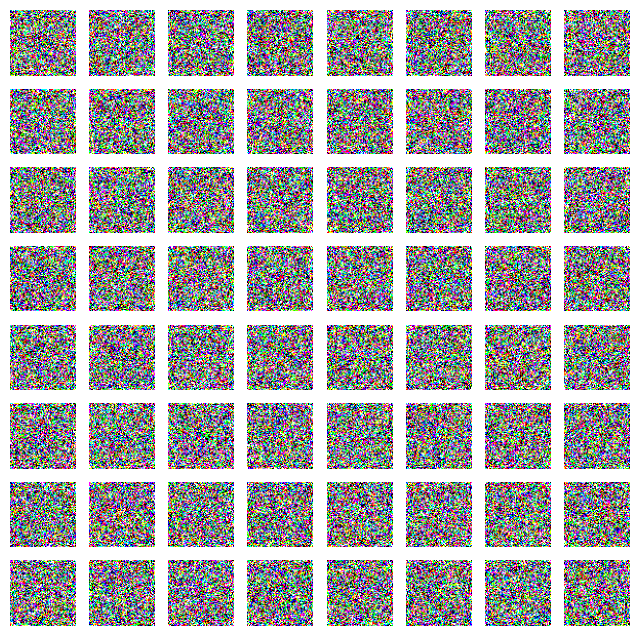

<tf.Tensor: shape=(), dtype=float32, numpy=1.7207327>

In [19]:
real = next(iter(data.unbatch().batch(64)))
diffusion_model.evaluate(real, plot=True, diffusion_steps=100)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:14<00:00, 13.43it/s]


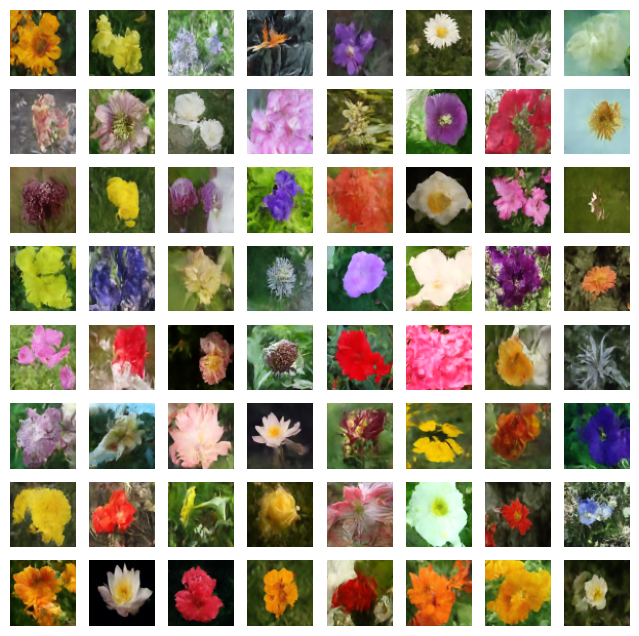

<tf.Tensor: shape=(), dtype=float32, numpy=0.30834222>

In [ ]:
# Evaluate the model
real = next(iter(data.unbatch().batch(64)))
diffusion_model.evaluate(real, plot=True, diffusion_steps=1000)
# imgs = diffusion_model.generate_images(num_images=64, diffusion_steps=800)
# plotImages(imgs/ tf.reduce_max(imgs))

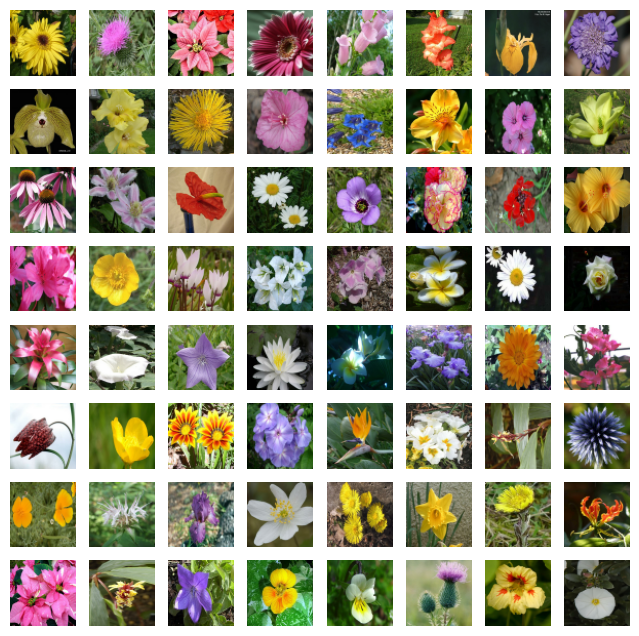

In [40]:
plotImages(real["image"])

2024-05-25 16:54:00.533207: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
1000it [01:02, 16.06it/s]


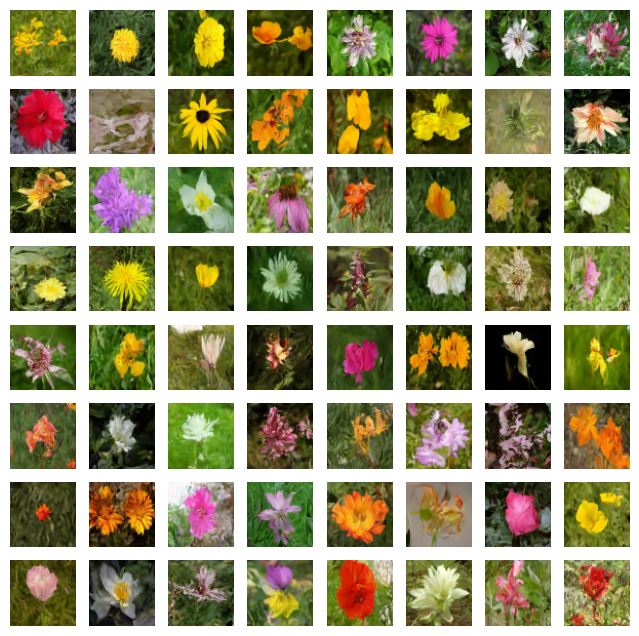

<tf.Tensor: shape=(), dtype=float32, numpy=0.17707896>

In [51]:
# Evaluate the model
real = next(iter(data.unbatch().batch(64)))
diffusion_model.evaluate(real, plot=True)

1000it [00:55, 17.94it/s]


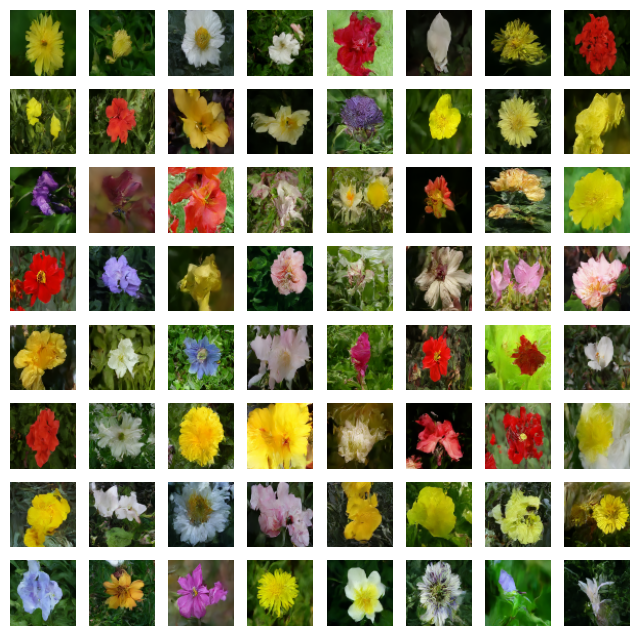

In [23]:
# diffusion_model.model = model
imgs = diffusion_model.generate_images(64)
plotImages(imgs)

1000it [01:00, 16.66it/s]


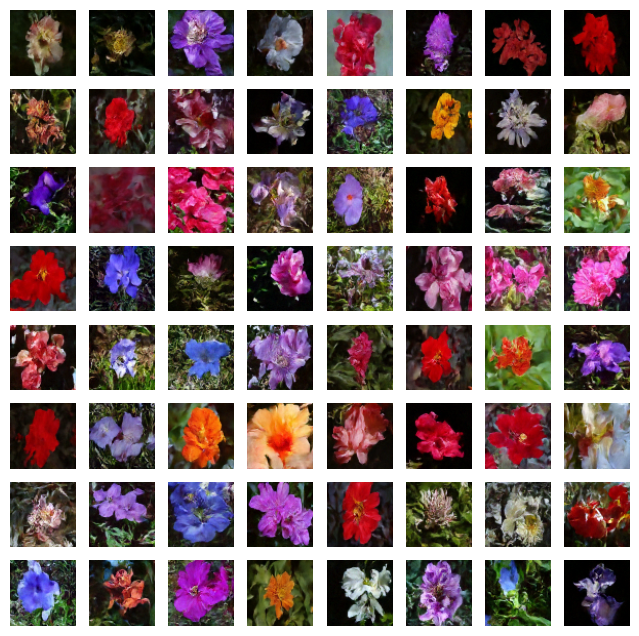

In [17]:
# diffusion_model.model = model
imgs = diffusion_model.generate_images(64)
plotImages(imgs)

1000it [00:54, 18.51it/s]


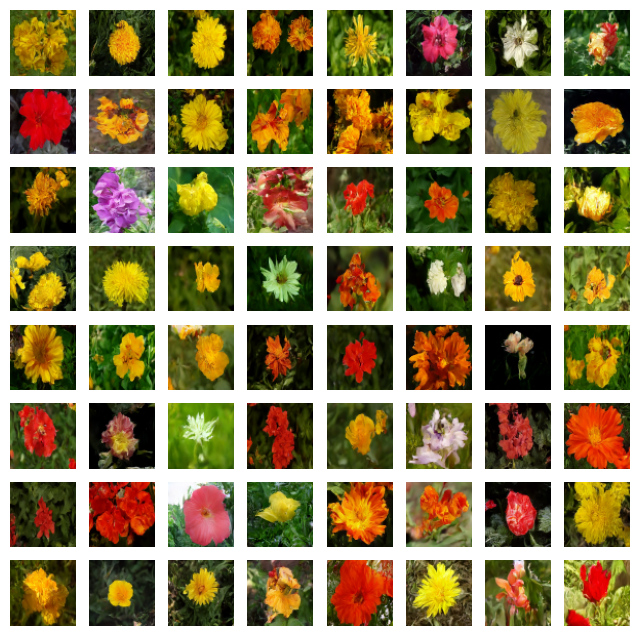

In [43]:
# diffusion_model.model = model
imgs = diffusion_model.generate_images(64)
plotImages(imgs)

2024-05-24 15:56:43.497805: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
1000it [00:58, 17.11it/s]


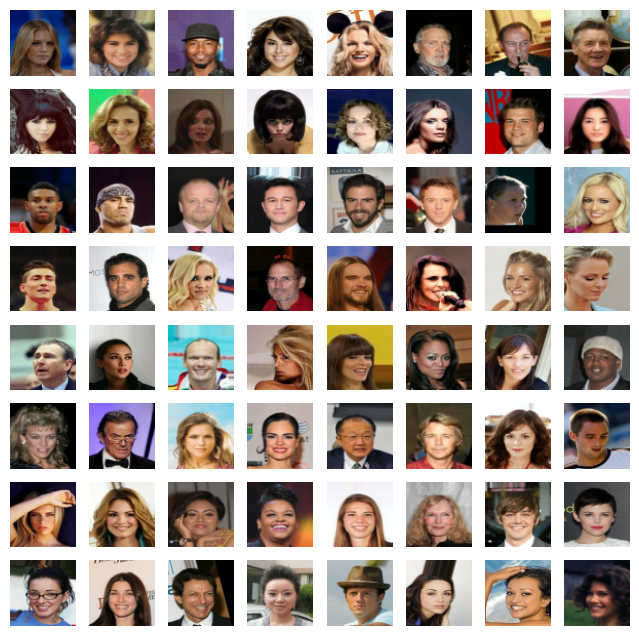

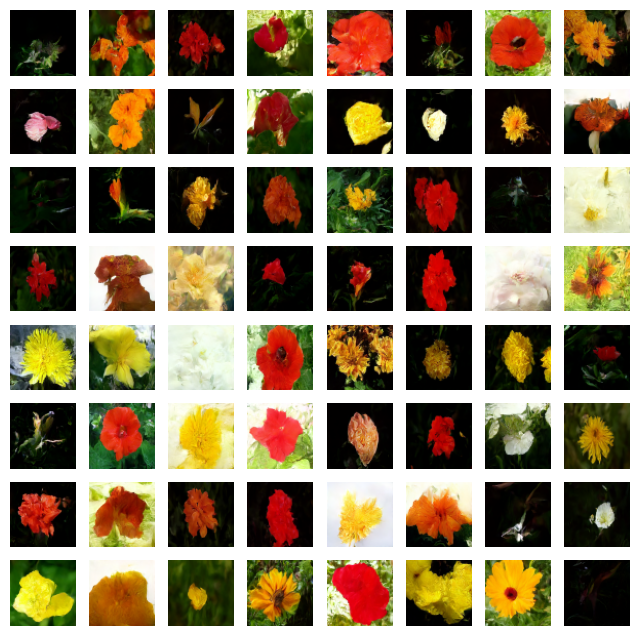

In [45]:
# Visualize adding some noise to some sample images and then removing it
data, _ = get_dataset("celeb_a", batch_size=64, image_scale=64)
images = next(iter(data))["image"]

# k = tf.random.normal(shape=[64, IMAGE_SCALE, IMAGE_SCALE, 3])
k = images
# k = l2normalizeImage(images + tf.random.normal(shape=[64, IMAGE_SCALE, IMAGE_SCALE, 3]))
o = diffusion_model.generate_images(64, priors=k, max_t=1000)
plotImages(k)
plotImages(o)

# DDIM Training

In [80]:
IMAGE_SCALE = 64
BATCH_SIZE = 16

tf.random.set_seed(42)

# Load the CelebA dataset
data, dateLen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SCALE)

STEPS = dateLen // BATCH_SIZE

model = generate_unet([IMAGE_SCALE, IMAGE_SCALE, 3], embedding_type="sinusoidal")
diffusion_model = VisionDiffusion(IMAGE_SCALE, model=model)


diffusion_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-4),
    loss=keras.losses.MeanSquaredError(),
    schedule=DDIMSchedule(timesteps=1000),
    jit_compile=True,
)
experiment_name = "{name}_{date}".format(
    name=f'{MODEL_NAME}_DDIM', date=datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
)
log_dir = os.path.join(TRAIN_LOGDIR, experiment_name)
# os.system("rm -rf ./{log_dir}".format(log_dir=TRAIN_LOGDIR))

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    update_freq="epoch",
    write_images=True,
    write_graph=True,
    histogram_freq=1,
)

monitor = Monitor(tf_logdir=log_dir)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss", patience=50, restore_best_weights=True, verbose=1, mode="min"
)


Residual Block: 4
Residual Block: 4
Residual Block: 8
Residual Block: 8
Residual Block: 16
Residual Block: 16
Residual Block: 32
Residual Block: 32


In [81]:
# Train the model
diffusion_model.fit(
    data, epochs=50, batch_size=BATCH_SIZE, steps_per_epoch=STEPS,
    callbacks=[tensorboard_callback, monitor],
)

# Save the model
diffusion_model.model.save(os.path.join(MODEL_PATH, f"{experiment_name}.keras"))

Epoch 1/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - loss: 0.1147 - n_loss: 0.1147
Epoch 2/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0445 - n_loss: 0.0445
Epoch 3/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0388 - n_loss: 0.0388
Epoch 4/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0374 - n_loss: 0.0374
Epoch 5/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0362 - n_loss: 0.0362
Epoch 6/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0362 - n_loss: 0.0362
Epoch 7/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0349 - n_loss: 0.0349
Epoch 8/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0342 - n_loss: 0.0342
Epoch 9/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0346 - n_loss: 0.0346
Epoch 10/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.0338 - n_loss: 0.0338
Epoch 11/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0331 - n_loss: 0.0331
Epoch 12/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/st

100%|██████████| 1000/1000 [00:56<00:00, 17.56it/s]


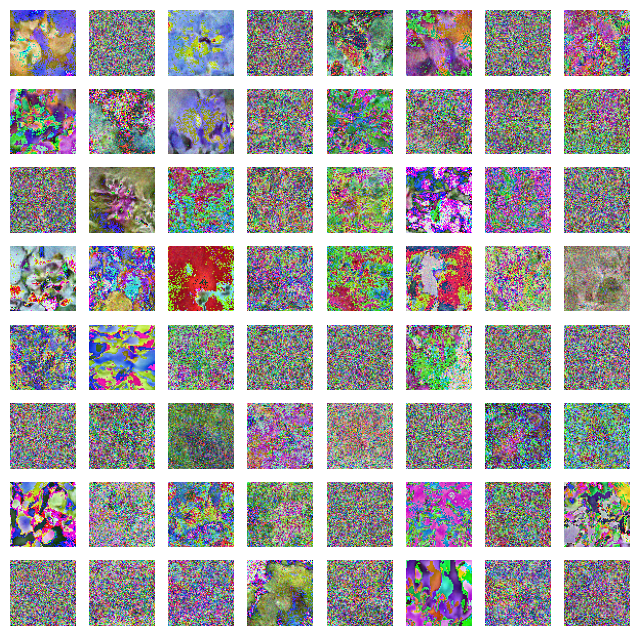

<tf.Tensor: shape=(), dtype=float32, numpy=0.75402045>

In [83]:
# Evaluate the model
real = next(iter(data.unbatch().batch(64)))
diffusion_model.evaluate(real, plot=True, max_t=1000)

# Official Keras Implementation

In [15]:
batch_size = 24
num_epochs = 1  # Just for the sake of demonstration
total_timesteps = 1000
norm_groups = 8  # Number of groups used in GroupNormalization layer
learning_rate = 2e-4

img_size = 64
img_channels = 3
clip_min = -1.0
clip_max = 1.0

first_conv_channels = 64
channel_multiplier = [1, 2, 4, 8]
widths = [first_conv_channels * mult for mult in channel_multiplier]
num_res_blocks = 1  # Number of residual blocks

def ResidualBlock(width, groups=8, activation_fn=keras.activations.swish):
    def apply(inputs):
        x, t = inputs
        input_width = x.shape[3]

        if input_width == width:
            residual = x
        else:
            residual = conv_layer(
                "separable",
                width, kernel_size=1, initializer=kernel_init(1.0)
            )(x)

        temb = activation_fn(t)
        temb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(temb)[
            :, None, None, :
        ]

        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = conv_layer(
            "separable",
            width, kernel_size=3, padding="same", initializer=kernel_init(1.0)
        )(x)

        x = layers.Add()([x, temb])
        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)

        x = conv_layer(
            "separable",
            width, kernel_size=3, padding="same", initializer=kernel_init(0.0)
        )(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownSample(width):
    def apply(x):
        x = conv_layer(
            "separable",
            width,
            kernel_size=3,
            strides=2,
            padding="same",
            initializer=kernel_init(1.0),
        )(x)
        return x

    return apply


def UpSample(width, interpolation="nearest"):
    def apply(x):
        x = layers.UpSampling2D(size=2, interpolation=interpolation)(x)
        x = conv_layer(
            "separable",
            width, kernel_size=3, padding="same", initializer=kernel_init(1.0)
        )(x)
        return x

    return apply


def build_model(
    img_size=IMAGE_SCALE,
    img_channels=3,
    widths=widths,
    has_attention=[False, False, True, True],
    num_res_blocks=2,
    norm_groups=8,
    interpolation="nearest",
    activation_fn=keras.activations.swish,
):
    image_input = layers.Input(shape=(img_size, img_size, img_channels), name="image_input")
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")

    x = conv_layer(
        "separable",
        first_conv_channels,
        kernel_size=(3, 3),
        padding="same",
        initializer=kernel_init(1.0),
    )(image_input)

    temb = TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)

    skips = [x]

    # DownBlock
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            skips.append(x)

        if widths[i] != widths[-1]:
            x = DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)(
        [x, temb]
    )
    x = AttentionBlock(widths[-1], groups=norm_groups)(x)
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)(
        [x, temb]
    )

    # UpBlock
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)

        if i != 0:
            x = UpSample(widths[i], interpolation=interpolation)(x)

    # End block
    x = layers.GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = layers.Conv2D(3, (3, 3), padding="same", kernel_initializer=kernel_init(0.0))(x)
    return keras.Model([image_input, time_input], x, name="unet")

In [16]:
class DiffusionModel(keras.Model):
    def __init__(self, network, timesteps, gdf_util, ema=0.999):
        super().__init__()
        self.network = network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema

    def train_step(self, data):
        # 1. Get the batch size
        images = data["image"]
        batch_size = tf.shape(images)[0]

        # 2. Sample timesteps uniformly
        t = tf.random.uniform(
            minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64
        )

        with tf.GradientTape() as tape:
            # 3. Sample random noise to be added to the images in the batch
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)

            # 4. Diffuse the images with noise
            images_t = self.gdf_util.q_sample(images, t, noise)

            # 5. Pass the diffused images and time steps to the network
            pred_noise = self.network([images_t, t], training=True)

            # 6. Calculate the loss
            loss = self.loss(noise, pred_noise)

        # 7. Get the gradients
        gradients = tape.gradient(loss, self.network.trainable_weights)

        # 8. Update the weights of the network
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # 10. Return loss values
        return {"loss": loss}

    def generate_images(self, num_images=16):
        # 1. Randomly sample noise (starting point for reverse process)
        samples = tf.random.normal(
            shape=(num_images, img_size, img_size, img_channels), dtype=tf.float32
        )
        # 2. Sample from the model iteratively
        for t in reversed(range(0, self.timesteps)):
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            pred_noise = self.network.predict(
                [samples, tt], verbose=0, batch_size=num_images
            )
            samples = self.gdf_util.p_sample(
                pred_noise, samples, tt, clip_denoised=True
            )
        # 3. Return generated samples
        return samples

    def plot_images(
        self, epoch=None, logs=None, num_rows=2, num_cols=8, figsize=(12, 5)
    ):
        """Utility to plot images using the diffusion model during training."""
        generated_samples = self.generate_images(num_images=num_rows * num_cols)
        generated_samples = (
            tf.clip_by_value(generated_samples * 127.5 + 127.5, 0.0, 255.0)
            .numpy()
            .astype(np.uint8)
        )

        _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i, image in enumerate(generated_samples):
            if num_rows == 1:
                ax[i].imshow(image)
                ax[i].axis("off")
            else:
                ax[i // num_cols, i % num_cols].imshow(image)
                ax[i // num_cols, i % num_cols].axis("off")

        plt.tight_layout()
        plt.show()


# Build the unet model
network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=keras.activations.swish,
)

In [ ]:
network.summary()

In [18]:
# Get an instance of the Gaussian Diffusion utilities
gdf_util = GaussianDiffusion(timesteps=total_timesteps)

# Get the model
model = DiffusionModel(
    network=network,
    gdf_util=gdf_util,
    timesteps=total_timesteps,
)

# Compile the model
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
)
batch_size=16
# Load the CelebA dataset
data, dateLen = get_dataset("oxford_flowers102", batch_size=batch_size, image_scale=img_size)

# Train the model
model.fit(
    data,
    epochs=100,
    batch_size=batch_size,
    steps_per_epoch=dateLen // batch_size,
    # callbacks=[keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images)],
)

Epoch 1/100


I0000 00:00:1716398818.871016  145657 service.cc:145] XLA service 0x72beec003d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716398818.871136  145657 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-05-22 22:56:59.294500: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1716398819.813500  145657 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
2024-05-22 22:57:00.761858: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1716398822.122569  146194 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_7', 4 bytes spill store

  5/511 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.9851  

I0000 00:00:1716398835.304938  145657 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-05-22 22:57:15.317230: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1566] failed to allocate 2.00GiB (2147483648 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


511/511 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - loss: 0.2361
Epoch 2/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0799
Epoch 3/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0715
Epoch 4/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0650
Epoch 5/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0621
Epoch 6/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0574
Epoch 7/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0568
Epoch 8/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0554
Epoch 9/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0521
Epoch 10/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.0531
Epoch 11/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.0501
Epoch 12/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.0519
Epoch 13/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.0501
Epoch 14/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0490
Epoch 15/100
511/511 ━━━━━━

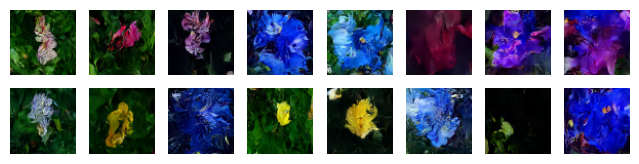

In [19]:
wnsample = downsample_layers.pop()
            x = layers.Concatenate()([x, downsample])
            x = residual_block(
                x,
                temb,
                features,
                5,
                1,
                "same",
                activation=activation_fn,
                direction="up",
                res=res,
                groups=norm_groups,
            )
            if should_attention:
                x = At# diffusion_model.model = model
imgs = model.generate_images(16)
plotImages(imgs)